# Image segmentation task for Cells

## Content
1. Make DataLoader
2. Make model (U-net)
3. Train Model
4. Evaluate model


U-Net: Convolutional Networks for Biomedical Image Segmentation, Ronneberger 2015

* Problem: not many data samples
* Solution: Data augmentation (elastic deformations) and U-Net architecture 

This is a supervised segmentation task, we provide pixel-by-pixel labelled data for each input and train the model to provide labelled data. The target image 

U-Net architecture --> feature generator
* Has contracting path (with pooling operators) to capture context
* Symmetric expanding path (with upsampling operators) that enables localisation

**Challenges**
* Convolutional layers downsample

To do (prioritised)

1. Study loss function closer... what is it?
   1. Add weighted loss with pre-computed weights
   2. Convert labels into longs/ integers.
2. Normalisation of training data
3. Data Augmentation 
4. Fix downsampling issue, by reflection

## Data Preparation

What is a PyTorch Dataset?

`torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

* `__len__` so that `len(dataset)` returns the size of the dataset.

* `__getitem__` to support the indexing such that `dataset[i]` can be used to get iith sample.

https://discuss.pytorch.org/t/unet-pixel-wise-weighted-loss-function/46689/5
https://discuss.pytorch.org/t/weighted-pixelwise-nllloss2d/7766/10

In [35]:
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms
import torchvision
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import random

In [36]:
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [37]:
train_transformations = transforms.Compose([
    # transforms.Normalize(0., 255.),
    # transforms.RandomAffine(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomRotation(),
    # Add Elastic transformation soon
    ])

In [38]:
class MembraneDataset(Dataset):
    # Map-style dataset
    def __init__(self, img_dir, transform = None, train=True):
        self.img_dir = img_dir
        self.transform = transform
        self.train = train

        if self.train:
            self.extension = '/train/'
        else:
            self.extension = '/test/'

        self.img_dir += self.extension
    def __len__(self):
        files = os.listdir(self.img_dir + 'image/')
        try:
            files.remove('.DS_Store')
        except ValueError:
            pass
        return len(files)

    def __getitem__(self, idx):
        img_path = self.img_dir + 'image/'+ str(idx) + '.png'
        image = read_image(img_path)

        label_path = self.img_dir + 'label/'+ str(idx) + '.png'
        label = read_image(label_path)

        if self.transform:
            seed = np.random.randint(2147483647) # make a seed with numpy generator 
            random.seed(seed) # apply this seed to img tranfsorms
            torch.manual_seed(seed) # needed for torchvision 0.7

            image = self.transform(image)

            random.seed(seed) # apply this seed to target tranfsorms
            torch.manual_seed(seed) # needed for torchvision 0.7

            label = self.transform(label)
            label = transforms.CenterCrop(324)(label)
        # if self.target_transform:
        #     label = self.target_transform(label)
        return image.float()/255, label.float()/255

training_data = MembraneDataset('./data/membrane', transform=train_transformations)
test_data = MembraneDataset('./data/membrane', train=False)

In [39]:
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [40]:
images, labels = next(iter(train_dataloader))

Feature batch shape: torch.Size([1, 1, 512, 512])
Labels batch shape: torch.Size([1, 1, 324, 324])


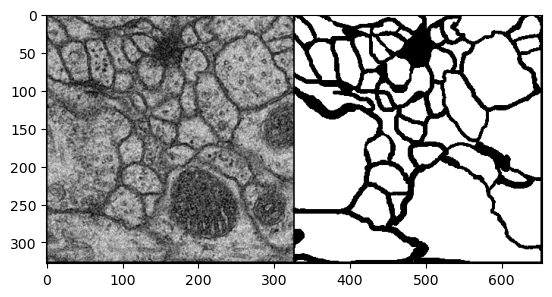

In [41]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

plt.imshow(np.transpose(torchvision.utils.make_grid([transforms.CenterCrop(324)(images[0]), labels[0]]), (1,2,0)))

## Define Model

<img src="./img/u-net-architecture.png" width="600" >

In [42]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class Block(nn.Module):
    # A block implements the 3x3 convolution and ReLU operation
    def __init__(self, in_channels, out_channels):
        # in_channels: number of input channels of the block
        # out_channels: number of output channels of the block
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3)

    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

class Encoder(nn.Module):
    def __init__(self, channels=(1,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(channels[i], channels[i+1]) for i in range(len(channels)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        # Generates list of image features (more images), downsampled
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

class Decoder(nn.Module):
    def __init__(self, channels=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.channels   = channels
        # Make lists of operations to apply
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(channels[i], channels[i+1], 2, 2) for i in range(len(channels)-1)])
        self.dec_blocks = nn.ModuleList([Block(channels[i], channels[i+1]) for i in range(len(channels)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.channels)-1):
            x        = self.upconvs[i](x) # Apply upconvolution operation
            enc_ftrs = self.crop(encoder_features[i], x) # Crop to match image size change due to convolution
            x        = torch.cat([x, enc_ftrs], dim=1) # Apply concatenation
            x        = self.dec_blocks[i](x) # Apply decoder block
        return x
    
    def crop(self, enc_ftrs, x):
        # Crops enc_ftrs to match shape of x
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [19]:
class UNet(nn.Module):
    # Choose num_classes = 1 to use BCE loss
    def __init__(self, enc_chs=(1,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_size=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_size = out_size

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_size)
        return out

net = UNet()
# net.to(device)
params = list(net.parameters())
print(len(params))

46


In [20]:
# enc_block = Block(1, 64)
# x         = torch.randn(1, 1, 572, 572)
# enc_block(x).shape


# encoder = Encoder()
# # input image
# x    = torch.randn(1, 1, 572, 572)
# ftrs = encoder(x)
# for ftr in ftrs: print(ftr.shape)

## Define Training Loop

### Paper Description
The energy function is computed by a pixel-wise soft-max over the final feature map combined with the cross entropy loss function. The **soft-max** is defined as $$p_k(\mathbf{x}) = \frac{\exp(a_k(\mathbf{x}))} {\sum _{k'=1}^{K} \exp(a_{k'}(\mathbf{x}))}$$
where $a_k(x)$ denotes the
activation in feature channel $k$ at the pixel position $\mathbf{x} \in \Omega$ with $\Omega ⊂ Z^2$. $K=2$ is the number of classes and $p_k(\mathbf{x})$ is the approximated maximum-function. I.e. $p_k(\mathbf{x}) \approx 1$ for the k that has the maximum activation $a_k(\mathbf{x})$ and $p_k(\mathbf{x}) \approx 0$ for all other $k$. (Makes sense!)

The **cross entropy** then penalizes at each position the deviation of $p_{\ell(\mathbf{x})}(\mathbf{x})$ from 1 using
$$E = \sum_{x \in \Omega} w(\mathbf{x}) \log(p_{\ell(\mathbf{x})}(\mathbf{x}))$$

where $\ell : Ω → \{1,...,K\}$ is the true label of each pixel and $w : Ω → \mathbb{R}$ is a weight map that we introduced to give some pixels more importance in the training.
We pre-compute the weight map for each ground truth segmentation to compensate the different frequency of pixels from a certain class in the training data set, and to force the network to learn the small separation borders that we introduce between touching cells (See Figure 3c and d).
The separation border is computed using morphological operations. The weight map is then computed as


$$􏰂 (d1(x) + d2(x))2 􏰃 w(x)=wc(x)+w0 ·exp − 2σ2 $$


### PyTorch Implementation
PyTorch confusingly calls the combination of these two things its `CrossEntropyLoss`.
* This criterion computes the cross entropy loss between input logits and target.
* The input is expected to contain the __unnormalized logits__ for each class (which do not need to be positive or sum to 1, in general).

In [21]:
import torch.optim as optim
weight = torch.tensor([0.8, 0.2])

sigmoid = nn.Sigmoid()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.99)

In [22]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # inputs = inputs.to(device)
        # labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        # print(inputs.shape, labels.shape, outputs.shape)
        # print(outputs)
        # plt.imshow(outputs.detach().numpy()[0,0])
        # plt.colorbar()
        loss = criterion(sigmoid(outputs), labels)
        loss.backward()
        optimizer.step()
        # break
        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
        running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.700
[1,     2] loss: 0.701


KeyboardInterrupt: 

In [23]:
model_output = outputs.detach().numpy()

In [24]:
outputs.shape, labels.shape

(torch.Size([1, 1, 324, 324]), torch.Size([1, 1, 324, 324]))

In [25]:
labels

tensor([[[[1., 1., 1.,  ..., 1., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 1., 0., 0.],
          [1., 1., 1.,  ..., 1., 1., 0.]]]])

In [26]:
print(criterion(sigmoid(outputs), labels))
print(criterion(labels, labels))
print(criterion(torch.ones_like(labels)*1, labels))
print(criterion(torch.ones_like(labels)*torch.mean(labels), labels))
print(criterion(torch.ones_like(labels)*0, labels))

tensor(0.7019, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.)
tensor(20.9305)
tensor(0.5130)
tensor(79.0695)


In [27]:
torch.mean(labels)

tensor(0.7907)

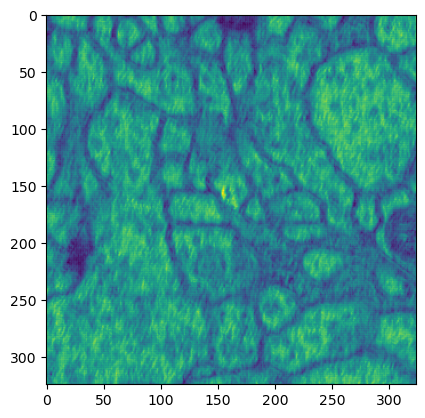

In [28]:
plt.imshow(model_output[0,0])

Testing

In [29]:
im, lbl = next(iter(train_dataloader))

In [30]:
label = transforms.CenterCrop(324)(lbl)[0]

In [31]:
# im= im.to(device)
# label = label.to(device)

NameError: name 'device' is not defined

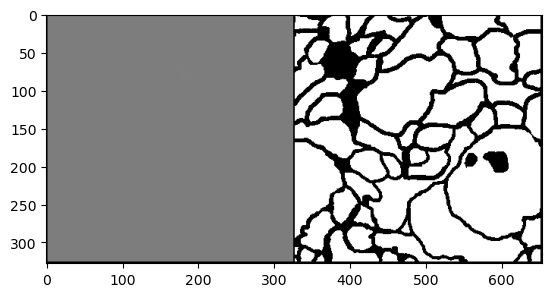

In [34]:
with torch.no_grad():
    pred = sigmoid((net(im))[0])

    # thresh = 0.5
    # pred[pred<thresh] = 0
    # pred[pred>=thresh] = 1

    plt.imshow(np.transpose(torchvision.utils.make_grid([pred.cpu(), label.cpu() ]), (1,2,0)))
    # plt.imshow(np.array(net(im))[0,0])